In [4]:
import pandas as pd

whisper_with_groundtruth= pd.read_csv(
    "whisper_with_groundtruth_100.csv",
    dtype={
        "speaker_id": str,
        "chapter_id": str,
        "sentence_id": str
    }
)


In [18]:
whisper_with_groundtruth.describe(include='all')


,speaker_id,chapter_id,sentence_id,file_path,whisper_transcript,ground_truth,similarity,wav2vec_transcript
count,28539,28539,28539,28539,28539,28539,28539.000000,0
unique,251,585,133,28539,28537,28537,NaN,0
top,211,61334,0000,/Users/christinexu/Desktop/MLDS/spring2025/clo...,and longitude 17 degrees.,and longitude seventeen degrees,NaN,NaN
freq,166,133,585,1,2,2,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,0.863989,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,0.157741,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.816933,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,0.932432,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,0.964912,NaN


In [8]:
whisper_with_groundtruth['file_path'][0]

'/Users/christinexu/Desktop/MLDS/spring2025/cloud_text_projects/text_proj/data/LS_train100/train-clean-100/1069/133709/1069-133709-0000.flac'

In [35]:
import difflib

def similarity_ratio(a, b):
    return difflib.SequenceMatcher(None, a, b).ratio()

import string

# Clean whisper_transcript: lowercase + remove punctuation
whisper_with_groundtruth['whisper_transcript_clean'] = whisper_with_groundtruth['whisper_transcript'].astype(str).apply(
    lambda x: x.lower().translate(str.maketrans('', '', string.punctuation))
)
whisper_with_groundtruth['ground_truth_clean'] = whisper_with_groundtruth['ground_truth'].astype(str).apply(
    lambda x: x.lower().translate(str.maketrans('', '', string.punctuation))
)

# Apply similarity calculation to each row
whisper_with_groundtruth['similarity'] = whisper_with_groundtruth.apply(
    lambda row: similarity_ratio(str(row['whisper_transcript_clean']), str(row['ground_truth_clean'])),
    axis=1
)

In [38]:
row = whisper_with_groundtruth.loc[0]
print("Whisper Transcript:       ", row['whisper_transcript'])
print("Ground Truth:             ", row['ground_truth'])
print("Whisper Transcript Clean: ", row['whisper_transcript_clean'])
print("Ground Truth Clean:       ", row['ground_truth_clean'])
print("Similarity:               ", row['similarity'])

Whisper Transcript:        had laid before her a pair of alternatives. Now, of course, you're completely your own mistress and are as free as the bird on the bow. I don't mean you are not so before, but you're at present on a different footing.
Ground Truth:              had laid before her a pair of alternatives now of course you're completely your own mistress and are as free as the bird on the bough i don't mean you were not so before but you're at present on a different footing
Whisper Transcript Clean:  had laid before her a pair of alternatives now of course youre completely your own mistress and are as free as the bird on the bow i dont mean you are not so before but youre at present on a different footing
Ground Truth Clean:        had laid before her a pair of alternatives now of course youre completely your own mistress and are as free as the bird on the bough i dont mean you were not so before but youre at present on a different footing
Similarity:                0.906921241

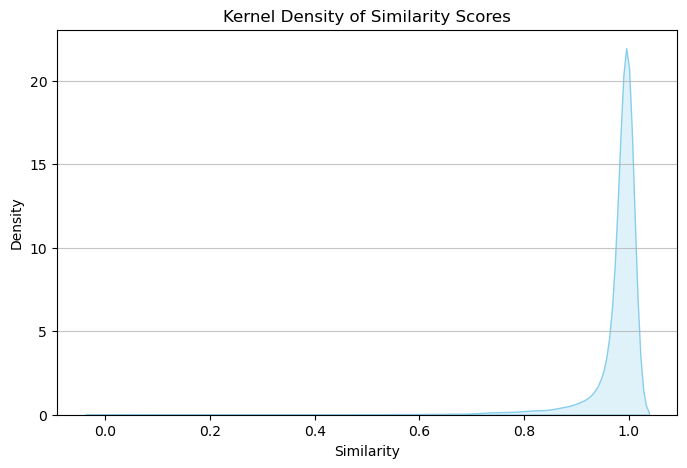

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.kdeplot(whisper_with_groundtruth['similarity'], fill=True, color='skyblue')
plt.title("Kernel Density of Similarity Scores")
plt.xlabel("Similarity")
plt.ylabel("Density")
plt.grid(axis='y', alpha=0.75)
plt.show()


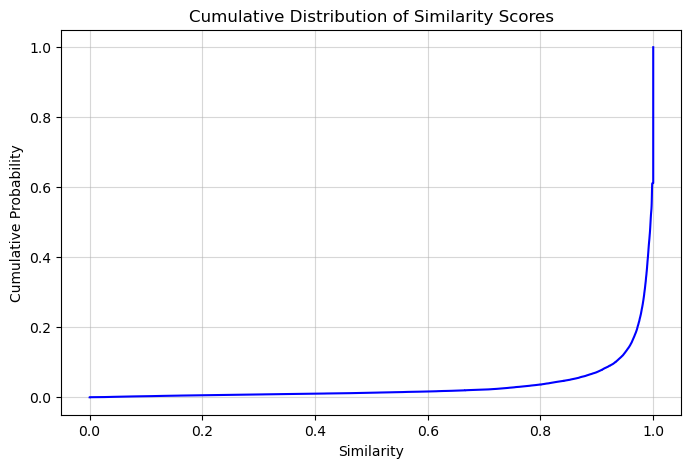

In [44]:
import numpy as np

sorted_scores = np.sort(whisper_with_groundtruth['similarity'])
cdf = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)

plt.figure(figsize=(8, 5))
plt.plot(sorted_scores, cdf, color='blue')
plt.title("Cumulative Distribution of Similarity Scores")
plt.xlabel("Similarity")
plt.ylabel("Cumulative Probability")
plt.grid(alpha=0.5)
plt.show()


In [15]:
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [54]:
import torch
import soundfile as sf
from pathlib import Path
import librosa
from tqdm import tqdm
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# Select best available device (CPU / MPS / CUDA)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load pretrained model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)

# Your audio base directory
my_audio_root = Path("/Users/juliachen/Documents/NU/Spring2025/Text Analysis/Final Project/LibriSpeech 2/train-clean-100")

# Add empty column for Wav2Vec2 transcripts
whisper_with_groundtruth["wav2vec_transcript"] = None

# Iterate through each row
for i, row in tqdm(whisper_with_groundtruth.iterrows(), total=len(whisper_with_groundtruth)):
    original_path = Path(row["file_path"])
    relative_path = Path(*original_path.parts[-3:])  # speaker/chapter/file.flac
    audio_path = my_audio_root / relative_path

    try:
        speech_array, sampling_rate = sf.read(audio_path)
    except Exception as e:
        print(f"Error reading {audio_path}: {e}")
        continue

    if sampling_rate != 16000:
        speech_array = librosa.resample(speech_array, orig_sr=sampling_rate, target_sr=16000)

    # Prepare input
    input_values = processor(speech_array, return_tensors="pt", sampling_rate=16000).input_values.to(device)

    # Inference
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])

    # Store result
    whisper_with_groundtruth.at[i, "wav2vec_transcript"] = transcription

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 28539/28539 [7:13:01<00:00,  1.10it/s]


In [55]:
whisper_with_groundtruth['wav2vec_transcript_clean'] = whisper_with_groundtruth['wav2vec_transcript'].astype(str).apply(
    lambda x: x.lower().translate(str.maketrans('', '', string.punctuation))
)

In [56]:
# Apply similarity calculation to each row
whisper_with_groundtruth['similarity_wav2vec'] = whisper_with_groundtruth.apply(
    lambda row: similarity_ratio(str(row['wav2vec_transcript_clean']), str(row['ground_truth_clean'])),
    axis=1
)

In [57]:
whisper_with_groundtruth.to_csv(
    "whisper_with_groundtruth_wav2vec_100.csv",
    index=False,
    encoding='utf-8-sig'
)

In [58]:
whisper_with_groundtruth

,speaker_id,chapter_id,sentence_id,file_path,whisper_transcript,ground_truth,similarity,wav2vec_transcript,whisper_transcript_clean,ground_truth_clean,wav2vec_transcript_clean,similarity_wav2vec
0,1069,133709,0000,/Users/christinexu/Desktop/MLDS/spring2025/clo...,had laid before her a pair of alternatives. No...,had laid before her a pair of alternatives now...,0.906921,HAD LAID BEFORE HER A PAIR OF ALTERNATIVES NOW...,had laid before her a pair of alternatives now...,had laid before her a pair of alternatives now...,had laid before her a pair of alternatives now...,1.000000
1,1069,133709,0041,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"vivid light of a judgment day. The girl, moreo...",livid light of a judgement day the girl moreov...,0.988142,VIVID LIGHT OF A JUDGMENT DAY THE GIRL MOREOVE...,vivid light of a judgment day the girl moreove...,livid light of a judgement day the girl moreov...,vivid light of a judgment day the girl moreove...,0.988142
2,1069,133709,0016,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"asked Isabella Breply, why, as a kind of compl...",asked isabel abruptly why as a kind of complim...,0.982353,ASKED ISABEL ABRUPTLY WHY AS A KIND OF COMPLIM...,asked isabella breply why as a kind of complim...,asked isabel abruptly why as a kind of complim...,asked isabel abruptly why as a kind of complim...,1.000000
3,1069,133709,0036,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"grown used to feeling rich. The consciousness,...",grown used to feeling rich the consciousness i...,1.000000,GROWN USED TO FEELING RICH THE CONSCIOUSNESS I...,grown used to feeling rich the consciousness i...,grown used to feeling rich the consciousness i...,grown used to feeling rich the consciousness i...,1.000000
4,1069,133709,0020,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"Henrietta doesn't. Oh, hang Henrietta, said Ra...",henrietta doesn't oh hang henrietta said ralph...,0.990937,HENRIETTA DOESN'T OH HANG HENRIETTA SAID RALPH...,henrietta doesnt oh hang henrietta said ralph ...,henrietta doesnt oh hang henrietta said ralph ...,henrietta doesnt oh hang henrietta said ralph ...,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
28534,5022,29411,0006,/Users/christinexu/Desktop/MLDS/spring2025/clo...,Neither of these anticipations was realized. O...,neither of these anticipations was realized on...,0.980501,NEITHER OF THESE ANTICIPATIONS WAS REALIZED ON...,neither of these anticipations was realized on...,neither of these anticipations was realized on...,neither of these anticipations was realized on...,0.997230
28535,5022,29411,0051,/Users/christinexu/Desktop/MLDS/spring2025/clo...,There was an hysterical defiance in her manner...,there was an hysterical defiance in her manner...,0.978723,THERE WAS AN HYSTERICAL DEFIANCE IN HER MANNER...,there was an hysterical defiance in her manner...,there was an hysterical defiance in her manner...,there was an hysterical defiance in her manner...,0.997647
28536,5022,29411,0026,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"I've got burdens on my mind,"" he explained, or...",i've got burdens on my mind he explained or i ...,0.969325,I'VE GOT BURDENS ON MY MIND HE EXPLAINED OR I ...,ive got burdens on my mind he explained or i s...,ive got burdens on my mind he explained or i s...,ive got burdens on my mind he explained or i s...,1.000000
28537,5022,29411,0067,/Users/christinexu/Desktop/MLDS/spring2025/clo...,Explain it who can. I knew that I was going to...,explain it who can i knew that i was going to ...,0.997691,EXPLAIN IT WHO CAN I KNEW THAT I WAS GOING TO ...,explain it who can i knew that i was going to ...,explain it who can i knew that i was going to ...,explain it who can i knew that i was going to ...,1.000000


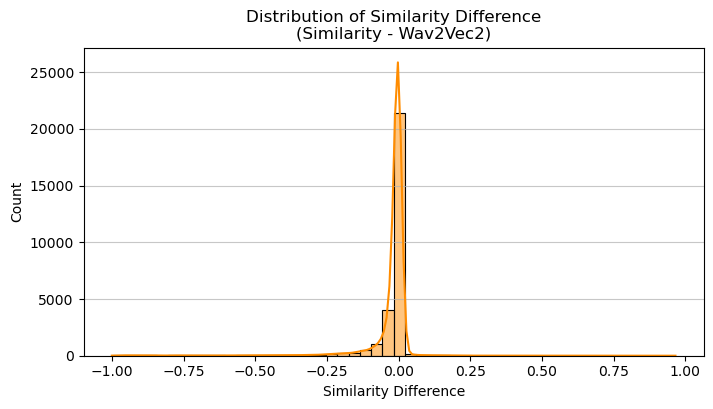

In [62]:
# Use actual column names from whisper_with_groundtruth
# Drop rows with missing values in either column
df = whisper_with_groundtruth[['similarity', 'similarity_wav2vec']].dropna()

# Compute the difference
df['similarity_diff'] = df['similarity'] - df['similarity_wav2vec']

# Plot the distribution of differences
plt.figure(figsize=(8, 4))
sns.histplot(df['similarity_diff'], bins=50, kde=True, color='darkorange')
plt.title("Distribution of Similarity Difference\n(Similarity - Wav2Vec2)")
plt.xlabel("Similarity Difference")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.7)
plt.show()


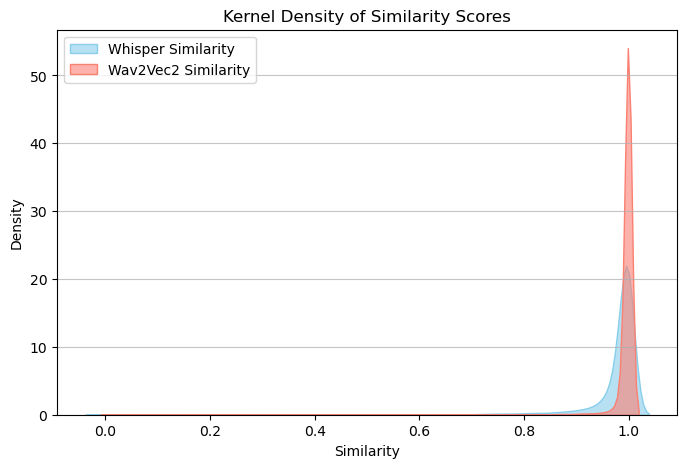

In [64]:
# Use already-existing DataFrame: whisper_with_groundtruth
# Drop rows with missing values in either similarity column
df = whisper_with_groundtruth[['similarity', 'similarity_wav2vec']].dropna()

# KDE Plot for both similarity columns
plt.figure(figsize=(8, 5))
sns.kdeplot(df['similarity'], fill=True, label='Whisper Similarity', color='skyblue', alpha=0.6)
sns.kdeplot(df['similarity_wav2vec'], fill=True, label='Wav2Vec2 Similarity', color='salmon', alpha=0.6)

plt.title("Kernel Density of Similarity Scores")
plt.xlabel("Similarity")
plt.ylabel("Density")
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()


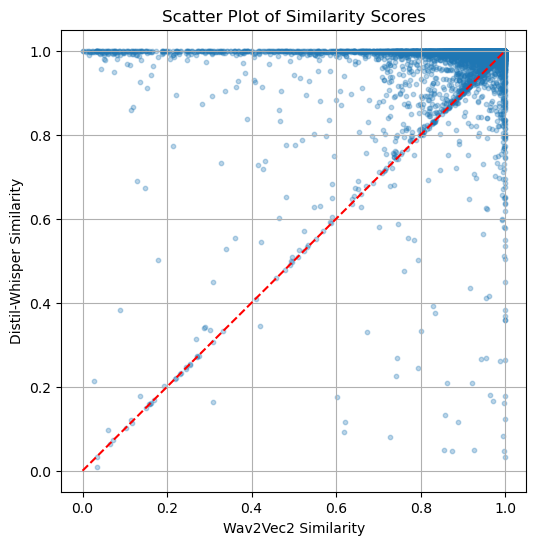

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(
    whisper_with_groundtruth['similarity'],
    whisper_with_groundtruth['similarity_wav2vec'],
    alpha=0.3, s=10
)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # identity line
plt.xlabel("Wav2Vec2 Similarity")
plt.ylabel("Distil-Whisper Similarity")
plt.title("Scatter Plot of Similarity Scores")
plt.grid(True)
plt.show()

In [45]:
import torch
import soundfile as sf
from pathlib import Path
import librosa
from tqdm import tqdm
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# Choose device (M1/M2/M3 = "mps", fallback to CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)

# Set your audio base path
my_audio_root = Path("/Users/juliachen/Documents/NU/Spring2025/Text Analysis/Final Project/LibriSpeech 2/train-clean-100")

# Filter only rows with low similarity
low_sim_rows = whisper_with_groundtruth[whisper_with_groundtruth["similarity"] < 0.8].copy()

# Initialize new column
low_sim_rows["wav2vec_transcript"] = None

# Transcribe only those rows
for i, row in tqdm(low_sim_rows.iterrows(), total=len(low_sim_rows)):
    original_path = Path(row["file_path"])
    relative_path = Path(*original_path.parts[-3:])
    audio_path = my_audio_root / relative_path

    try:
        speech_array, sampling_rate = sf.read(audio_path)
    except Exception as e:
        print(f"Error reading {audio_path}: {e}")
        continue

    if sampling_rate != 16000:
        speech_array = librosa.resample(speech_array, orig_sr=sampling_rate, target_sr=16000)

    input_values = processor(speech_array, return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])

    low_sim_rows.at[i, "wav2vec_transcript"] = transcription


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1031/1031 [02:39<00:00,  6.47it/s]


In [47]:
low_sim_rows

,speaker_id,chapter_id,sentence_id,file_path,whisper_transcript,ground_truth,similarity,wav2vec_transcript,whisper_transcript_clean,ground_truth_clean
23,1069,133709,0008,/Users/christinexu/Desktop/MLDS/spring2025/clo...,but was never over-inquisitive as regards the ...,but was never over inquisitive as regards the ...,0.507659,BUT WAS NEVER OVER INQUISITIVE AS REGARDS THE ...,but was never overinquisitive as regards the t...,but was never over inquisitive as regards the ...
82,1069,133699,0052,/Users/christinexu/Desktop/MLDS/spring2025/clo...,I shall never think of anyone else. I came to ...,i shall never think of any one else i came to ...,0.534314,I SHALL NEVER THINK OF ANY ONE ELSE I CAME TO ...,i shall never think of anyone else i came to e...,i shall never think of any one else i came to ...
89,1069,133699,0032,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"But his eyes asked it, and his hands shake whe...",but his eyes asked it and his handshake when h...,0.481572,BUT HIS EYES ASKED IT AND HIS HANDSHAKE WHEN H...,but his eyes asked it and his hands shake when...,but his eyes asked it and his handshake when h...
112,8580,287364,0031,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"A moment later, the young inventor was bowled ...",a moment later the young inventor was bowled o...,0.710407,A MOMENT LATER THE YOUNG INVENTOR WAS BOWLED O...,a moment later the young inventor was bowled o...,a moment later the young inventor was bowled o...
188,8580,287363,0022,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"And yet we are how far away above the earth, T...",and yet we are how far are we above the earth ...,0.152174,AND YET WE ARE HOW FAR ARE WE ABOVE THE EARTH ...,and yet we are how far away above the earth to...,and yet we are how far are we above the earth ...
...,...,...,...,...,...,...,...,...,...,...
28502,5022,29411,0034,/Users/christinexu/Desktop/MLDS/spring2025/clo...,and should remember the circumstance with plea...,and should remember the circumstance with plea...,0.341880,AND SHOULD REMEMBER THE CIRCUMSTANCE WITH PLEA...,and should remember the circumstance with plea...,and should remember the circumstance with plea...
28504,5022,29411,0022,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"But, Mr. Taller, I objected. Something must ha...",but mister toller i objected something must ha...,0.799107,BUT MISTER TOLLER I OBJECTED SOMETHING MUST HA...,but mr taller i objected something must have h...,but mister toller i objected something must ha...
28511,5022,29411,0001,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"Still, while crystals and treaties and crystal...",still while cristel's entreaties and cristel's...,0.724444,STILL WHILE CRISTEL'S ENTREATIES IN CRISTEL'S ...,still while crystals and treaties and crystals...,still while cristels entreaties and cristels i...
28517,5022,29411,0020,/Users/christinexu/Desktop/MLDS/spring2025/clo...,about Crystal. After looking around the kitche...,about cristel after looking round the kitchen ...,0.129159,ABOUT CRISTEL AFTER LOOKING AROUND THE KITCHEN...,about crystal after looking around the kitchen...,about cristel after looking round the kitchen ...


In [51]:
low_sim_rows['wav2vec_transcript_clean'] = low_sim_rows['wav2vec_transcript'].astype(str).apply(
    lambda x: x.lower().translate(str.maketrans('', '', string.punctuation))
)

In [52]:
# Apply similarity calculation to each row
low_sim_rows['similarity_wav2vec'] = low_sim_rows.apply(
    lambda row: similarity_ratio(str(row['wav2vec_transcript_clean']), str(row['ground_truth_clean'])),
    axis=1
)

In [53]:
low_sim_rows

,speaker_id,chapter_id,sentence_id,file_path,whisper_transcript,ground_truth,similarity,wav2vec_transcript,whisper_transcript_clean,ground_truth_clean,wav2vec_transcript_clean,similarity_wav2vec
23,1069,133709,0008,/Users/christinexu/Desktop/MLDS/spring2025/clo...,but was never over-inquisitive as regards the ...,but was never over inquisitive as regards the ...,0.507659,BUT WAS NEVER OVER INQUISITIVE AS REGARDS THE ...,but was never overinquisitive as regards the t...,but was never over inquisitive as regards the ...,but was never over inquisitive as regards the ...,0.997802
82,1069,133699,0052,/Users/christinexu/Desktop/MLDS/spring2025/clo...,I shall never think of anyone else. I came to ...,i shall never think of any one else i came to ...,0.534314,I SHALL NEVER THINK OF ANY ONE ELSE I CAME TO ...,i shall never think of anyone else i came to e...,i shall never think of any one else i came to ...,i shall never think of any one else i came to ...,0.537897
89,1069,133699,0032,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"But his eyes asked it, and his hands shake whe...",but his eyes asked it and his handshake when h...,0.481572,BUT HIS EYES ASKED IT AND HIS HANDSHAKE WHEN H...,but his eyes asked it and his hands shake when...,but his eyes asked it and his handshake when h...,but his eyes asked it and his handshake when h...,1.000000
112,8580,287364,0031,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"A moment later, the young inventor was bowled ...",a moment later the young inventor was bowled o...,0.710407,A MOMENT LATER THE YOUNG INVENTOR WAS BOWLED O...,a moment later the young inventor was bowled o...,a moment later the young inventor was bowled o...,a moment later the young inventor was bowled o...,0.811530
188,8580,287363,0022,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"And yet we are how far away above the earth, T...",and yet we are how far are we above the earth ...,0.152174,AND YET WE ARE HOW FAR ARE WE ABOVE THE EARTH ...,and yet we are how far away above the earth to...,and yet we are how far are we above the earth ...,and yet we are how far are we above the earth ...,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
28502,5022,29411,0034,/Users/christinexu/Desktop/MLDS/spring2025/clo...,and should remember the circumstance with plea...,and should remember the circumstance with plea...,0.341880,AND SHOULD REMEMBER THE CIRCUMSTANCE WITH PLEA...,and should remember the circumstance with plea...,and should remember the circumstance with plea...,and should remember the circumstance with plea...,1.000000
28504,5022,29411,0022,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"But, Mr. Taller, I objected. Something must ha...",but mister toller i objected something must ha...,0.799107,BUT MISTER TOLLER I OBJECTED SOMETHING MUST HA...,but mr taller i objected something must have h...,but mister toller i objected something must ha...,but mister toller i objected something must ha...,1.000000
28511,5022,29411,0001,/Users/christinexu/Desktop/MLDS/spring2025/clo...,"Still, while crystals and treaties and crystal...",still while cristel's entreaties and cristel's...,0.724444,STILL WHILE CRISTEL'S ENTREATIES IN CRISTEL'S ...,still while crystals and treaties and crystals...,still while cristels entreaties and cristels i...,still while cristels entreaties in cristels in...,0.977578
28517,5022,29411,0020,/Users/christinexu/Desktop/MLDS/spring2025/clo...,about Crystal. After looking around the kitche...,about cristel after looking round the kitchen ...,0.129159,ABOUT CRISTEL AFTER LOOKING AROUND THE KITCHEN...,about crystal after looking around the kitchen...,about cristel after looking round the kitchen ...,about cristel after looking around the kitchen...,0.990215
